# 1. Variable importance and Model selection

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import gc  #memory management
#
#Setting styles and aesthetics
pd.set_option('display.max_columns', 200)
pd.options.display.max_rows =30
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 8)

In [4]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

In [5]:
# Check The Shape Of The Data Loaded
print('Train data shape: {} Rows, {} Columns'.format(*train.shape))
display(train.head(3))
#
print('Test data shape: {} Rows, {} Columns'.format(*test.shape))
display(test.head(3))

Train data shape: 5472 Rows, 29 Columns


,customer_id,insured_period,residential,building_painted,building_fenced,garden,settlement,target,insured_period_round,scaled_building_dim,year_of_observation,year_of_occupancy,years_active,year_of_observation_freq_encode,year_of_occupancy_freq_encode,years_active_freq_encode,building_type_2,building_type_3,building_type_4,quarter_Q2,quarter_Q3,quarter_Q4,decades_active_D2,decades_active_D3,decades_active_D4,decades_active_D5,decades_active_D6,decades_active_D7,decades_active_D8
0,H14663,1.00,0,1,0,1,0,0.00,12,0.06,2013,1960,53,2093,3733,989,0,0,0,0,0,1,0,0,0,0,1,0,0
1,H3802,1.00,0,1,0,1,0,0.00,12,0.13,2014,1960,54,1517,3733,680,0,0,0,0,0,1,0,0,0,0,1,0,0
2,H3834,1.00,0,0,0,1,0,0.00,12,0.61,2013,1960,53,2093,3733,989,0,0,0,0,0,1,0,0,0,0,1,0,0


Test data shape: 2674 Rows, 28 Columns


,customer_id,insured_period,residential,building_painted,building_fenced,garden,settlement,insured_period_round,scaled_building_dim,year_of_observation,year_of_occupancy,years_active,year_of_observation_freq_encode,year_of_occupancy_freq_encode,years_active_freq_encode,building_type_2,building_type_3,building_type_4,quarter_Q2,quarter_Q3,quarter_Q4,decades_active_D2,decades_active_D3,decades_active_D4,decades_active_D5,decades_active_D6,decades_active_D7,decades_active_D8
0,H11920,1.00,0,0,1,0,1,12,0.06,2013,1960,53,2093,3733,989,0,0,0,0,0,1,0,0,0,0,1,0,0
1,H11921,1.00,0,0,1,0,1,12,0.06,2016,1960,56,1093,3733,457,0,0,0,0,0,1,0,0,0,0,1,0,0
2,H9805,0.37,0,0,0,1,0,5,0.17,2013,1960,53,2093,3733,989,0,0,0,1,0,0,0,0,0,0,1,0,0


## 1.1 Feature Importance

We implement our own recursive feature elimination method

In [6]:
# modelling 
import lightgbm as lgb
#
# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [7]:
y = train.target.astype(int)
X = train.drop(['target', 'customer_id'], axis=1)

In [8]:
# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 1500, 
                           class_weight = 'balanced')

In [9]:
train_columns = ['insured_period', 'residential', 'building_painted', 'building_fenced',
       'garden', 'settlement', 'insured_period_round', 'scaled_building_dim',
       'year_of_observation', 'year_of_occupancy', 'years_active',
       'year_of_observation_freq_encode', 'year_of_occupancy_freq_encode',
       'years_active_freq_encode', 'building_type_2', 'building_type_3',
       'building_type_4', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4',
       'decades_active_D2', 'decades_active_D3', 'decades_active_D4',
       'decades_active_D5', 'decades_active_D6', 'decades_active_D7',
       'decades_active_D8']

In [10]:
# Split into training and validation set
import random
random.seed(123)
#
train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 27)
# Train using early stopping
model.fit(train_features, train_y, 
          eval_metric = 'logloss', 
          verbose = 200)

LGBMClassifier(boosting_type='goss', class_weight='balanced', n_estimators=1500,
               objective='binary')

In [11]:
#define a function to create variable importance dataframe
def get_lgbm_varimp(model, train_columns, max_vars=50):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df

In [12]:
get_lgbm_varimp(model, train_columns)

,feature_name,varimp (%)
7,scaled_building_dim,42.96
13,years_active_freq_encode,10.61
10,years_active,8.70
8,year_of_observation,5.51
12,year_of_occupancy_freq_encode,4.45
14,building_type_2,4.22
0,insured_period,3.98
2,building_painted,3.49
9,year_of_occupancy,3.33
1,residential,2.98


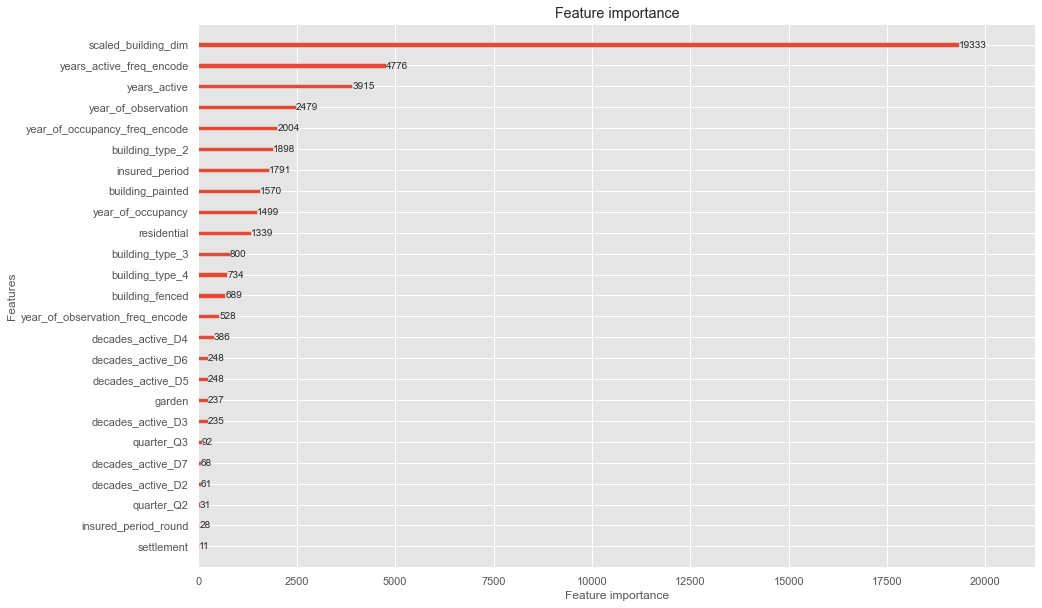

In [13]:
#plot feature importance
#plot the variable importance
ax=lgb.plot_importance(model, max_num_features=50, figsize=(15,10))
plt.show()

In [14]:
#drop irrelevant columns/variables from X features
columns = ['quarter_Q4', 'decades_active_D8']
#
X.drop(columns, inplace=True, axis=1)

## 1.2 Model Selection
Identify the best model with higher accuracy from a list of classifier models

**Calculate the Baseline of our models**

In [15]:
#split model
import random
random.seed(1234)
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#
#model the training set and calculate the metrics
clf = lgb.LGBMClassifier().fit(x_train, y_train)
#
from sklearn.metrics import log_loss, accuracy_score
print('Log Loss: ', log_loss(y_valid, clf.predict_proba(x_valid)))
print('Accuracy: ', accuracy_score(y_valid, clf.predict(x_valid)))

Log Loss:  0.5209927017685076
Accuracy:  0.792326431181486


In [16]:
print('X_train: ', x_train.shape, 'X_test: ', x_valid.shape, 'y_train: ', y_train.shape, 'y_test: ', y_valid.shape)

X_train:  (3830, 25) X_test:  (1642, 25) y_train:  (3830,) y_test:  (1642,)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier #Neural networks
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import log_loss, accuracy_score
#
models = [
    RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0),
    SVC(decision_function_shape="ovo"),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', penalty='l2', dual = False),
    AdaBoostClassifier(),
    CatBoostClassifier(iterations=300, depth=6, learning_rate=0.1, logging_level='Silent',
                        eval_metric='Accuracy', random_state=42),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(objective='binary:logistic', eval_metric='logloss', learning_rate=0.1, max_depth=4, seed=27,
                  n_estimators=100),
    lgb.LGBMClassifier(objective='binary', 
                           boosting_type = 'goss', 
                           n_estimators = 1500, 
                           class_weight = 'balanced'),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1),
    DecisionTreeClassifier(max_depth = 2)
]
#
kfold = KFold(n_splits=5, random_state=7)
CV = 5
#
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print(cv_df.groupby('model_name').accuracy.mean().sort_values())

model_name
LGBMClassifier               0.70
KNeighborsClassifier         0.77
CatBoostClassifier           0.78
AdaBoostClassifier           0.80
DecisionTreeClassifier       0.80
MLPClassifier                0.80
RandomForestClassifier       0.80
SVC                          0.80
GradientBoostingClassifier   0.80
LogisticRegression           0.80
XGBClassifier                0.80
Name: accuracy, dtype: float64


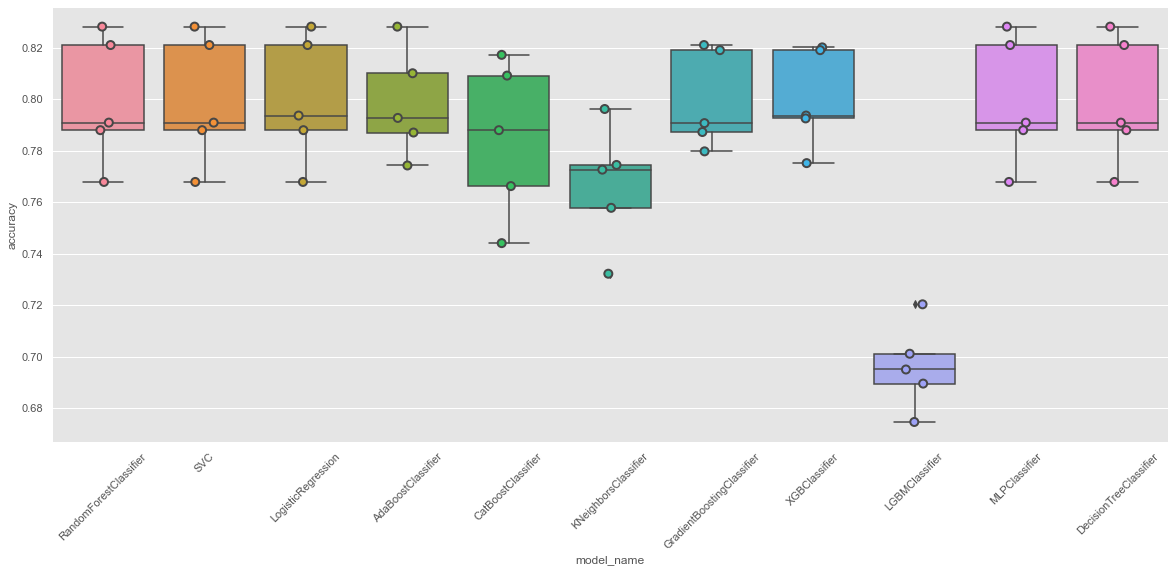

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

## 1.3 Parameter Tuning
We use **GridsearchCV** to find the best hyper-parameters for the model

In [19]:
from sklearn.model_selection import GridSearchCV
#
#dictionary of hyper-parameters
dual=[True,False]
max_iter=[100,110,120,130,140]
C = [1.0,1.5,2.0,2.5]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

In [20]:
lr = LogisticRegression(penalty='l2')
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = kfold, n_jobs=-1)
#
grid_result = grid.fit(X, y)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.801350 using {'C': 2.0, 'dual': False, 'max_iter': 120}


In [21]:
#params = {
#    'max_depth': range(3,10,2),
#    'min_child_weight': range(1,6,2),
#    'learning_rate': [0.01, 0.02, 0.03, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
#    'n_estimators': range(0,1000,100)
#}
#
#xgb = XGBClassifier(seed = 27)
#grid = GridSearchCV(estimator = xgb, param_grid = params, cv = kfold, n_jobs=-1)
#
#grid_result = grid.fit(X, y)
# Summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [22]:
lr = LogisticRegression(penalty='l2', C = 2.0, dual = False, max_iter = 120)
lr.fit(x_train, y_train)
#
#
lr_pred=lr.predict(x_valid)
#
print('Log Loss: ', log_loss(y_valid, lr.predict_proba(x_valid)))
print("Accuracy:", accuracy_score(y_valid, lr_pred))
#
from sklearn.metrics import mean_squared_error, classification_report
mse=mean_squared_error(y_valid, lr_pred)
print('LogisticRegression-RMSE: ', np.sqrt(mse))
#
#classification Report
print(classification_report(y_valid, lr_pred))

Log Loss:  0.4757782539918324
Accuracy: 0.8069427527405603
LogisticRegression-RMSE:  0.43938280264416324
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1322
           1       0.56      0.04      0.08       320

    accuracy                           0.81      1642
   macro avg       0.69      0.52      0.49      1642
weighted avg       0.76      0.81      0.73      1642



### Area Under Curve

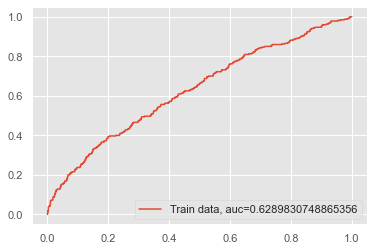

In [27]:
from sklearn.metrics import roc_curve
y_proba = lr.predict_proba(x_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_proba)
auc = roc_auc_score(y_valid, y_proba)
plt.plot(fpr, tpr, label="Train data, auc=" + str(auc))
plt.legend(loc=4)
plt.show()

In [37]:
#predict the test data set
pred = lr.predict(test.drop(['customer_id', 'quarter_Q4', 'decades_active_D8'], axis = 1))
#
tst = pd.read_csv('test_data.csv')
submission = test[['customer_id']]
submission['Claim'] = pd.DataFrame(pred)
submission

,customer_id,Claim
0,H11920,0
1,H11921,0
2,H9805,0
3,H7493,0
4,H7494,0
...,...,...
2669,H11416,0
2670,H11568,0
2671,H11720,0
2672,H11721,0


In [35]:
submission.to_csv('LogisticReg_submission.csv',index=False) #export the predicted values as csv 